In [1]:
!pip install ruptures

     |████████████████████████████████| 921kB 5.6MB/s 


In [5]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from time import *
import re 
import math 

In [6]:
app = pd.read_csv('/content/Apps_signatures - Apps_signatures.csv',delimiter=';')

# ***Data Preprocessing***

In [7]:
app.head()

,date,RealP1,RealP2,RealP3,AppP1,AppP2,AppP3,Irms1,Irms2,Irms3,Vrms1,Vrms2,Vrms3,PowerF1,PowerF2,PowerF3,Appareil
0,2019-08-02T16:41:21.518Z,-0.98,33.63,15.91,-0.98,64.67,85.06,0.17,0.25,0.32,262.22,261.16,262.44,0.000,0.510,0.176,Cafetière
1,2019-08-02T16:41:23.570Z,-2.87,41.41,13.84,-2.87,66.04,85.76,0.19,0.25,0.33,261.52,262.43,261.82,0.039,0.621,0.152,Cafetière
2,2019-08-02T16:41:25.623Z,-0.28,42.95,13.21,-0.28,85.55,89.84,0.17,0.33,0.34,262.15,260.99,262.34,0.000,0.491,0.145,Cafetière
3,2019-08-02T16:41:27.675Z,-0.37,40.84,13.67,-0.37,75.78,84.96,0.15,0.29,0.33,261.11,262.60,261.43,0.000,0.528,0.153,Cafetière
4,2019-08-02T16:41:29.728Z,-4.68,40.58,13.70,-4.68,70.35,89.85,0.19,0.27,0.34,262.15,261.29,262.20,0.080,0.569,0.145,Cafetière


In [8]:
#Calculer les puissances,l'energie,l'intensité totales.
app['RealP_tot'] = app['RealP1'] + app['RealP2'] + app['RealP3']
app['AppP_tot'] = app['AppP1'] + app['AppP2'] + app['AppP3']
app['Irms_tot'] = app['Irms1'] + app['Irms2'] + app['Irms3']
app['Vrms_tot'] = app['Vrms1'] + app['Vrms2'] + app['Vrms3']
app['PowerF_tot'] = app['PowerF1'] + app['PowerF2'] + app['PowerF3']

In [9]:
app.columns

Index(['date', 'RealP1', 'RealP2', 'RealP3', 'AppP1', 'AppP2', 'AppP3',
       'Irms1', 'Irms2', 'Irms3', 'Vrms1', 'Vrms2', 'Vrms3', 'PowerF1',
       'PowerF2', 'PowerF3', 'Appareil', 'RealP_tot', 'AppP_tot', 'Irms_tot',
       'Vrms_tot', 'PowerF_tot'],
      dtype='object')

In [10]:
app.drop(['RealP1', 'RealP2', 'RealP3', 'AppP1', 'AppP2', 'AppP3',
       'Irms1', 'Irms2', 'Irms3', 'Vrms1', 'Vrms2', 'Vrms3', 'PowerF1',
       'PowerF2', 'PowerF3'],1,inplace=True)

In [11]:
#puisque P = I * V on décide de supprimer  V (ou I c'st la méme chose)
app.drop(['Vrms_tot'],axis=1,inplace=True) 

In [12]:
#Lister les appareils disponibles.
app.Appareil.unique()

array(['Cafetière', 'ClimatiseurA', 'ClimatiseurB', 'Imprimante',
       'Micro-ondesB', 'Micro-ondesA', 'Réfrigérateur'], dtype=object)

In [13]:
#Liste des appareils
apps = ['Cafetière', 'ClimatiseurA', 'ClimatiseurB', 'Imprimante',
       'Micro-ondesB', 'Micro-ondesA', 'Réfrigérateur']

In [14]:
print(app.RealP_tot.min())
print(app.RealP_tot.max())
print(app.PowerF_tot.min())
print(app.PowerF_tot.max())

34.59
2179.58
0.547
1.879


In [15]:
#Calculer le Facteur Puissance (FP) ( entre 0 et 1)
app['FP'] = app['RealP_tot'] / app['AppP_tot']

In [16]:
#Compter le nombre de ligne par appareil.
app.groupby('Appareil').size()

Appareil
Cafetière        626
ClimatiseurA     498
ClimatiseurB     424
Imprimante       240
Micro-ondesA     420
Micro-ondesB     356
Réfrigérateur    844
dtype: int64

In [17]:
#Nombre de ligne dupliquées
app.duplicated().sum()

0

In [18]:
app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3408 entries, 0 to 3407
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        3408 non-null   object 
 1   Appareil    3408 non-null   object 
 2   RealP_tot   3408 non-null   float64
 3   AppP_tot    3408 non-null   float64
 4   Irms_tot    3408 non-null   float64
 5   PowerF_tot  3408 non-null   float64
 6   FP          3408 non-null   float64
dtypes: float64(5), object(2)
memory usage: 186.5+ KB


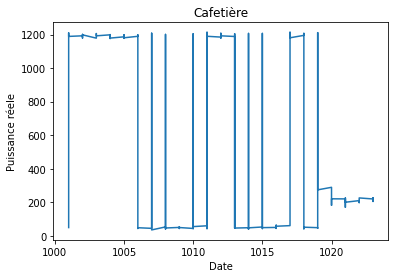

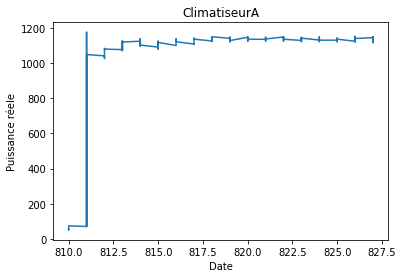

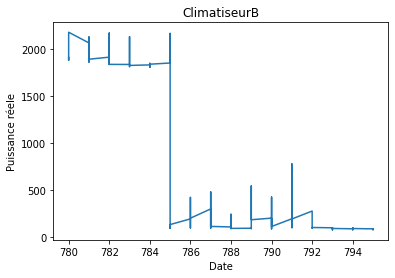

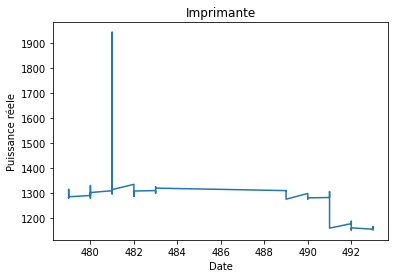

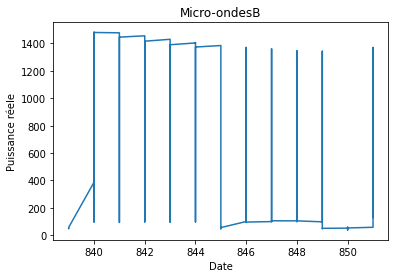

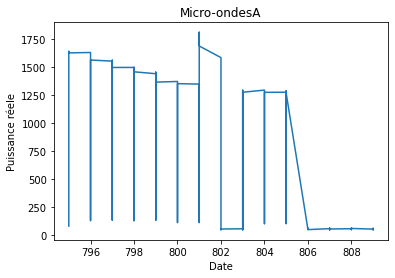

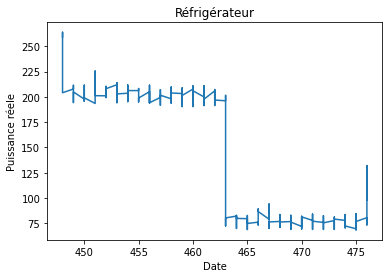

In [19]:
#visualiser la consommation de chaque appareil en fonction du temps.
for ap in apps:
    x = app[app['Appareil']==ap]
    pt = x['RealP_tot']
    dt = pd.to_datetime(x.date).dt.minute + pd.to_datetime(x.date).dt.hour * 60
    plt.plot(dt,pt)
    plt.xlabel('Date')
    plt.ylabel('Puissance réele')
    plt.title(ap)
    plt.show()

In [20]:
#les variables suivant peuvent étre utiles si les données couvrent une grande durée de temps(3 mois ou plus par exp)
#new_app['day_week'] = pd.to_datetime(new_app.date).dt.dayofweek
#new_app['day'] = pd.to_datetime(new_app.date).dt.day
#new_app['month'] = pd.to_datetime(new_app.date).dt.month
#Pour l'utiliser a la phase de détection des événement
app['hour'] = pd.to_datetime(app.date).dt.hour
app['minute'] = pd.to_datetime(app.date).dt.minute

In [21]:
app.head()

,date,Appareil,RealP_tot,AppP_tot,Irms_tot,PowerF_tot,FP,hour,minute
0,2019-08-02T16:41:21.518Z,Cafetière,48.56,148.75,0.74,0.686,0.326454,16,41
1,2019-08-02T16:41:23.570Z,Cafetière,52.38,148.93,0.77,0.812,0.351709,16,41
2,2019-08-02T16:41:25.623Z,Cafetière,55.88,175.11,0.84,0.636,0.319114,16,41
3,2019-08-02T16:41:27.675Z,Cafetière,54.14,160.37,0.77,0.681,0.337594,16,41
4,2019-08-02T16:41:29.728Z,Cafetière,49.60,155.52,0.80,0.794,0.318930,16,41


In [22]:
#Remarque :
###RealP_tot:'PuissanceActive'
###AppP_tot :'PuissanceApparente'
####Vrms_tot : 'Energie_totale'
###Irms_tot:'Intensité'

In [23]:
#Travailler sur une copie de données
app1 = app.copy()

In [24]:
#Convertir la colonne 'Appareil' en données numériques
le = LabelEncoder()
app1['Appareil'] = le.fit_transform(app1['Appareil'])

In [25]:
le.classes_

array(['Cafetière', 'ClimatiseurA', 'ClimatiseurB', 'Imprimante',
       'Micro-ondesA', 'Micro-ondesB', 'Réfrigérateur'], dtype=object)

In [26]:
#Liste d'appareils selon l'encodage
Appareils = ['Cafetière', 'ClimatiseurA', 'ClimatiseurB', 'Imprimante','Micro-ondesA', 'Micro-ondesB', 'Réfrigérateur']

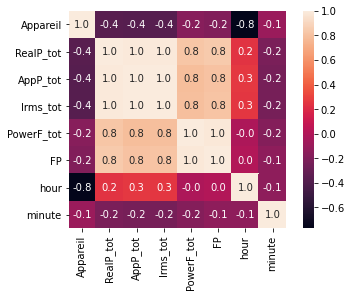

In [27]:
sns.heatmap(app1.corr(), annot=True, fmt=".1f",annot_kws={'size':10},square=True)

In [28]:
#Calculer la puissance réactive
app1['P_reactive'] = app1['AppP_tot']**2 - app1['RealP_tot']**2 
app['P_reactive'] = app['AppP_tot']**2 - app['RealP_tot']**2 

In [29]:
#On supprime 'AppP_tot' puisqu'il est totalement corrélée aux deux autres variables
app1.drop(['AppP_tot'],1,inplace=True)
app.drop(['AppP_tot'],1,inplace=True)

In [30]:
app1['date1'] = app1['hour'] * 60 + app1['minute']
app['date1'] = app['hour'] * 60 + app['minute']

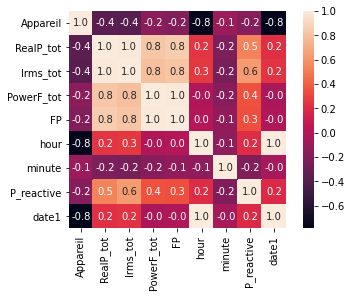

In [31]:
sns.heatmap(app1.corr(), annot=True, fmt=".1f",annot_kws={'size':10},square=True)

# ***Model Classification***

In [32]:
#on utilise une copie de données
app1.head()

,date,Appareil,RealP_tot,Irms_tot,PowerF_tot,FP,hour,minute,P_reactive,date1
0,2019-08-02T16:41:21.518Z,0,48.56,0.74,0.686,0.326454,16,41,19768.4889,1001
1,2019-08-02T16:41:23.570Z,0,52.38,0.77,0.812,0.351709,16,41,19436.4805,1001
2,2019-08-02T16:41:25.623Z,0,55.88,0.84,0.636,0.319114,16,41,27540.9377,1001
3,2019-08-02T16:41:27.675Z,0,54.14,0.77,0.681,0.337594,16,41,22787.3973,1001
4,2019-08-02T16:41:29.728Z,0,49.60,0.80,0.794,0.318930,16,41,21726.3104,1001


In [33]:
app1.drop(['date'],1,inplace=True)

In [34]:
app1.Appareil.value_counts()

6    844
0    626
1    498
2    424
4    420
5    356
3    240
Name: Appareil, dtype: int64

In [37]:
#On standarise les données par 'standard scaler'
#liste des colonnes a stadarisé 
lis = ['RealP_tot','Irms_tot','PowerF_tot','hour','FP','minute','P_reactive','date1']
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [38]:
for each in lis:
  app[each] = scaler.fit_transform(np.array(app[each]).reshape(-1,1))
  app1[each] = scaler.fit_transform(np.array(app1[each]).reshape(-1,1))

In [39]:
#app1 = app1.sample(frac = 1) 

In [40]:
y = app1.Appareil
x = app1.drop(['Appareil'],1)

In [41]:
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,random_state=42)

In [42]:
#cross validation
from sklearn.model_selection import cross_val_score

In [51]:
#Modéle1

In [43]:
rfr = RandomForestClassifier(n_estimators=200,max_depth=15,random_state=42,criterion='entropy')

In [44]:
scores = cross_val_score(rfr, x, y, cv=10)
scores

array([0.8973607 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98529412])

In [45]:
rfr.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [46]:
y_pred = rfr.predict(x_val)

In [47]:
accuracy_score(y_pred,y_val)

0.9970674486803519

In [52]:
#Modéle2

In [48]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

In [49]:
for k in range(3,16):
  knn = KNeighborsClassifier(n_neighbors=3)
  knn.fit(x_train, y_train)
  print(knn.score(x_val, y_val))

0.9970674486803519
0.9970674486803519
0.9970674486803519
0.9970674486803519
0.9970674486803519
0.9970674486803519
0.9970674486803519
0.9970674486803519
0.9970674486803519
0.9970674486803519
0.9970674486803519
0.9970674486803519
0.9970674486803519


In [53]:
#Modéle3

In [50]:
#GBC
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)
gbc.score(x_val, y_val)

0.9970674486803519

In [77]:
#Modéle4

In [78]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [80]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
svm_model = GridSearchCV(SVC(), params_grid, cv=10)
svm_model.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [81]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

Best score for training data: 0.9989010989010989 

Best C: 1000 

Best Kernel: linear 

Best Gamma: scale 



In [82]:
final_model = svm_model.best_estimator_
y_pred = final_model.predict(x_val)

In [83]:
accuracy_score(y_val,y_pred)

0.9970674486803519

In [ ]:
#from sklearn.multioutput import MultiOutputClassifier
#from xgboost import XGBClassifier

In [144]:

#LGB Model
import lightgbm as lgb
trn_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_val, label=y_val)

weight = 10
param = { 'num_leaves': 30,
    'boost': 'gbdt',
    'learning_rate': 0.02,
    'metric':'multi_logloss',
    'scale_pos_weight': round(weight, 1),
    'num_class':7,
    'max_depth':8,
    
 
    
    'objective': 'multiclass',
    'random_state': 42,
    
}


In [145]:
lgb_model = lgb.train(param, trn_data, 1000, valid_sets = [trn_data, val_data], 
                      verbose_eval=200, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[200]	training's multi_logloss: 0.0271293	valid_1's multi_logloss: 0.0294688
[400]	training's multi_logloss: 0.000680897	valid_1's multi_logloss: 0.00538637
Early stopping, best iteration is:
[375]	training's multi_logloss: 0.00106647	valid_1's multi_logloss: 0.00470276


In [146]:
pred1 = lgb_model.predict(x_val,num_iteration=lgb_model.best_iteration)

In [147]:
pred11 = [np.argmax(line) for line in pred1]

In [148]:
accuracy_score(pred11,y_val)

0.9970674486803519

In [ ]:
'''
#Enregister le modéle
import pickle
with open('model_pickle','wb') as model_rfr:
    pickle.dump(lgb_model,model_lgb)
'''

"\n#Enregister le modéle\nimport pickle\nwith open('model_pickle','wb') as model_rfr:\n    pickle.dump(lgb_model,model_lgb)\n"

# ***Event Détection & Machine Prediction (1)***

In [ ]:
app.head()

,date,Appareil,RealP_tot,AppP_tot,Irms_tot,PowerF_tot,FP,hour,minute,P_reactive,date1
0,2019-08-02T16:41:21.518Z,Cafetière,-0.985948,-0.981782,-0.989310,-1.950081,-1.627862,1.23663,0.646309,-0.663124,1.306683
1,2019-08-02T16:41:23.570Z,Cafetière,-0.979638,-0.981483,-0.976313,-1.579993,-1.522133,1.23663,0.646309,-0.665216,1.306683
2,2019-08-02T16:41:25.623Z,Cafetière,-0.973857,-0.937954,-0.945987,-2.096941,-1.658591,1.23663,0.646309,-0.614143,1.306683
3,2019-08-02T16:41:27.675Z,Cafetière,-0.976731,-0.962462,-0.976313,-1.964767,-1.581223,1.23663,0.646309,-0.644099,1.306683
4,2019-08-02T16:41:29.728Z,Cafetière,-0.984230,-0.970526,-0.963316,-1.632863,-1.659360,1.23663,0.646309,-0.650786,1.306683


In [ ]:
le = LabelEncoder()
app['Appareil'] = le.fit_transform(app['Appareil'] )

In [ ]:
app['date'] = pd.to_datetime(app['date'])

In [ ]:
#Change point détection
points = np.array(app['RealP_tot'])

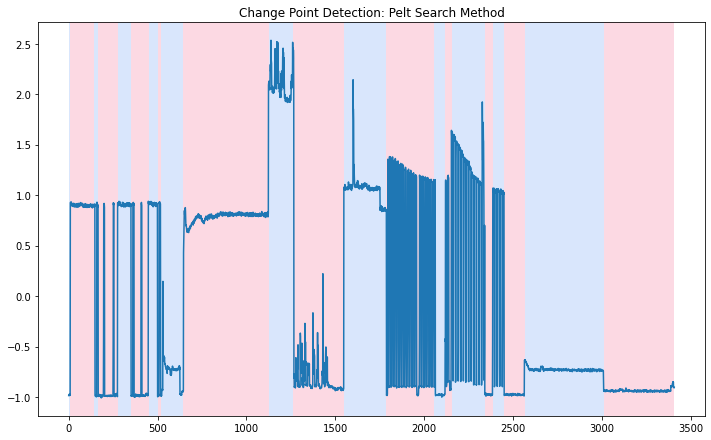

In [ ]:
#Changepoint detection with the Pelt search method , pen = 4 (the optimal "pen" that we have tested)

model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=4)
rpt.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show() 

In [ ]:
len(result)

22

In [ ]:
result

[10,
 145,
 165,
 275,
 350,
 450,
 500,
 520,
 645,
 1125,
 1265,
 1550,
 1785,
 2055,
 2120,
 2155,
 2340,
 2385,
 2450,
 2565,
 3010,
 3408]

In [ ]:
#on supprime le dernier élément du liste puisque il représente la fin du données
result.pop(-1)

3408

In [ ]:
#Fonction qui détermine l'élément le plus fréquent dans une liste
def top_frequency(lst): 
    k = 0
    n = lst[0]
    lst = list(lst)
    for i in lst: 
        freq = lst.count(i) 
        if(k < freq): 
            k = freq
            n = i 
    return n

In [ ]:
app.head()

,date,Appareil,RealP_tot,AppP_tot,Irms_tot,PowerF_tot,FP,hour,minute,P_reactive,date1
0,2019-08-02 16:41:21.518000+00:00,0,-0.985948,-0.981782,-0.989310,-1.950081,-1.627862,1.23663,0.646309,-0.663124,1.306683
1,2019-08-02 16:41:23.570000+00:00,0,-0.979638,-0.981483,-0.976313,-1.579993,-1.522133,1.23663,0.646309,-0.665216,1.306683
2,2019-08-02 16:41:25.623000+00:00,0,-0.973857,-0.937954,-0.945987,-2.096941,-1.658591,1.23663,0.646309,-0.614143,1.306683
3,2019-08-02 16:41:27.675000+00:00,0,-0.976731,-0.962462,-0.976313,-1.964767,-1.581223,1.23663,0.646309,-0.644099,1.306683
4,2019-08-02 16:41:29.728000+00:00,0,-0.984230,-0.970526,-0.963316,-1.632863,-1.659360,1.23663,0.646309,-0.650786,1.306683


In [ ]:
app.drop(['Appareil'],1,inplace=True)

In [ ]:
lch=[] #liste des appareils en marche
lch2=[] #Liste des appareils mis hors tension
list_deb =[] #liste des instants des débuts
list_fin =[] #liste des instants des fins
list_dur=[] #Liste des durées
list_apps =[] #Liste des appareils détectés
list_idx = [] # Liste des Index d'évenements

In [ ]:
#Le Principe était de prendre à chaque fois les lignes qui suivent une détection de changement
# et faire une prédiction ensuite de prende l'appareil le plus occurent comme résultat de prédiction

In [ ]:
######Prédiciton pour les lignes du premier évènement seulement

idx1 = result[0] #Premier index où l'évement été détecté
idx2 = result[1] #Index du prochain évènement
dtest = app.iloc[idx1:idx2] #La base sur laquelle on va prédire: Elle Commence de idx1 jusqu'à (idx2 - 1)

#dates du début et du fin
debut = dtest['date'].min() 
fin = dtest['date'].max()


diff = int(((dtest['date'].max() - dtest['date'].min()).seconds)) #durée entre les deux événement
duree = strftime('%H:%M:%S', gmtime(diff))
dtest.drop('date',inplace=True, axis=1)

#Prédiciton
ypred = rfr.predict(dtest)
appar = top_frequency(ypred) #Prendre l'appareil le plus occurent



#remplir les listes
list_apps.append(Appareils[appar])
list_deb.append(debut)
list_fin.append(fin)
list_dur.append(duree)
list_idx.append(idx1)


ch = Appareils[appar]
ch2 = '--'
lch.append(ch)
lch2.append(ch2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
list_apps

['Cafetière']

In [ ]:
#On répéte le méme processus sur les intervalles suivants

In [ ]:
#Prédiciton pour toutes les autres lignes sauf celles qui sont après la détection du dernier évenement 
for i in range(1,(len(result)-1)):
    idx1 = result[i] #Premier index où l'évement été détecté
    idx2 = result[i+1] #Index du prochain évènement
    pvar = app.iloc[idx2]['RealP_tot'] - app.iloc[idx1]['RealP_tot'] #C'est la variation en terme de puissance apparente
    #ou on peut prendre la différence des moyennes des intervalles consécutives

    pvar = round(pvar,3) #On prend juste 3 valeurs aprés la virgule

    
    #On conserve "dtest" qui contient les données entre les 2 points de changement précédentes
    dtest1 = app.iloc[idx1:idx2]

    #dates de début et du fin
    debut = dtest1['date'].min()
    fin = dtest1['date'].max()

    #durée du période en secondes
    diff = int(((dtest1['date'].max() - dtest1['date'].min()).seconds))
    duree = strftime('%H:%M:%S', gmtime(diff))
    dtest1.drop('date',inplace=True, axis=1)
    

    #Calcul des valeurs moyennes de l'intervalle précédent (dtest et non dtest1)
    RealP_mean = dtest['RealP_tot'].mean()
    PowerF_mean = dtest['PowerF_tot'].mean()
    Irms_mean = dtest['Irms_tot'].mean()
    #Les autres variables ( 'FP' et 'P_reactive') on les recalculer aprés la maj

    
    dtest1 = dtest1.reset_index(drop=True)

    #Mise a jour des données
    for k in range(len(dtest1)):
      dtest1.iloc[k]['RealP_tot'] = np.abs( dtest1.iloc[k]['RealP_tot'] - RealP_mean )
      dtest1.iloc[k]['PowerF_tot'] = np.abs( dtest1.iloc[k]['PowerF_tot'] - PowerF_mean )
      dtest1.iloc[k]['Irms_tot'] = np.abs( dtest1.iloc[k]['Irms_tot'] - Irms_mean )


    #recalcul des variables 'FP' et 'Preactive'
    dtest1['P_reactive'] = np.abs(dtest1['RealP_tot']**2 - dtest1['PowerF_tot']**2)
    dtest1['FP'] = dtest1['PowerF_tot'] / dtest1['RealP_tot']

    #On prend 3 entiers aprés la virgule     
    dtest1[['PowerF_tot','RealP_tot','P_reactive','FP']] = round(dtest1[['PowerF_tot','RealP_tot','P_reactive','FP']],3)
    

    
    #Prediction du machine       
    ypred = rfr.predict(dtest1)
    appar = top_frequency(ypred) 
    appar = Appareils[appar]

    #dtest1 sera dtest pour qu'on utilse dans la prochaine intervalle*****************
    dtest = app.iloc[idx1:idx2]

    #Ajout des informations obtenus
    list_apps.append(appar)
    list_deb.append(debut)
    list_fin.append(fin)
    list_dur.append(duree)
    list_idx.append(idx1)



    #Cette partie de code pour l'ajout du nom d'appareil dans la colonne de mis en marche ou bien de mis hors marche
    #cas1 : la valeur du puissance augmente , ilya ume machine (ou plus) qui est ajoutée
    if pvar > 0 : 
      if appar in ch: 
        b = "".join(re.findall("(\s+){}".format(appar), ch))
        if b.isspace() == False: #L'appareil exite q'une seukle fois
          if ch.find(appar) == 0:
            ch = '2'+ch
          else:
            c = "".join(re.findall("(\d+){}".format(appar), ch)) #déterminer le nombre de cette appareil qui existe
            ac = c + appar
            bc = str(int(c) + 1)+appar #addditionner le nombre d'apparition de cette machine
            ch= ch.replace(ac, bc)
        else: #si b est une espace , donc cette appareil existe q'une seule fois
          ch = ('2'+appar).join(ch.split(appar))
        ch2 = '--' #pour dire que l'appareil ajoutée déja existe
        lch.append(ch)
        lch2.append(ch2)
      else:
        ch = ch + ' ' + appar
        ch2 = '--' #pour dire que l'appareil ajoutée déja existe
        lch.append(ch)
        lch2.append(ch2)

        
    #pvar < 0 , ilya une appareil(plus q'un appareil ou juste un bruit ) débranchée
    else:
      if appar in ch: #si l'appareil prédictée existe (pour qu'on peut le supprimer ou décrémenter sa nombre )
      #sinon on néglige cette variation de puissance et on suppose que c'est la méme machine mais avec un autre niveau de puissance
        b = "".join(re.findall("(\s+){}".format(appar), ch))
        if b.isspace() == False:
          if ch.find(appar) == 0:
            ch = ch.replace(appar ,'') 
          else:
              c = "".join(re.findall("(\d+){}".format(appar), ch))
              ac = c+appar
              bc = str(int(c) - 1)+appar
              ch= ch.replace(ac, bc)
              ch = ch.replace('1','')
              ch = ' '.join(ch.split())
        else:
            ch = ch = ch.replace(appar ,'')
            ch = ' '.join(ch.split())
        ch2 = appar
        lch.append(ch)
        lch2.append(ch2)
      #l'appareil n'existe pas déja
      else:
        ch2 = appar
        lch.append(ch)
        lch2.append(ch2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.p

In [ ]:
#On applique aussi cette processus sur le dernier intervalle

In [ ]:
#Prédiciton pour les lignes après la détection du dernier évènement 

idx1 = result[-1] #dernier indice
idx2 = len(app) - 1 #dernier ligne 
pvar = app.iloc[idx2]['RealP_tot'] - app.iloc[idx1]['RealP_tot']
dtest1 = app.iloc[idx1:idx2]


debut = dtest1['date'].min()
fin = dtest1['date'].max()
diff = int(((dtest1['date'].max() - dtest1['date'].min()).seconds))
duree = strftime('%H:%M:%S', gmtime(diff))
dtest1.drop('date',inplace=True, axis=1)



#Calcul des valeurs moyennes de l'intervalle précédent (dtest et non dtest1)
RealP_mean = dtest['RealP_tot'].mean()
PowerF_mean = dtest['PowerF_tot'].mean()
Irms_mean = dtest['Irms_tot'].mean()
#Les autres variables ( 'FP' et 'P_reactive') on les recalculer aprés la maj

    
dtest1 = dtest1.reset_index(drop=True)

#Mise a jour des données
for k in range(len(dtest1)):
  dtest1.iloc[k]['RealP_tot'] = np.abs( dtest1.iloc[k]['RealP_tot'] - RealP_mean )
  dtest1.iloc[k]['PowerF_tot'] = np.abs( dtest1.iloc[k]['PowerF_tot'] - PowerF_mean )
  dtest1.iloc[k]['Irms_tot'] = np.abs( dtest1.iloc[k]['Irms_tot'] - Irms_mean )


#recalcul des variables 'FP' et 'Preactive'
dtest1['P_reactive'] = np.abs(dtest1['RealP_tot']**2 - dtest1['PowerF_tot']**2)
dtest1['FP'] = dtest1['PowerF_tot'] / dtest1['RealP_tot']

#On prend 3 entiers aprés la virgule     
dtest1[['PowerF_tot','RealP_tot','P_reactive','FP']] = round(dtest1[['PowerF_tot','RealP_tot','P_reactive','FP']],3)
 

#Prédiction 
ypred = rfr.predict(dtest1)
appar = top_frequency(ypred)

appar = Appareils[appar]


#Ajout des informations
list_apps.append(appar)
list_deb.append(debut)
list_fin.append(fin)
list_dur.append(duree)
list_idx.append(idx1)



if pvar > 0 :
  if appar in ch:
    b = "".join(re.findall("(\s+){}".format(appar), ch))
    if b.isspace() == False:
      if ch.find(appar) == 0:
        ch = '2'+ch
      else:
        c = "".join(re.findall("(\d+){}".format(appar), ch))
        ac = c+appar
        bc = str(int(c) + 1)+appar
        ch= ch.replace(ac, bc)
    else:
      ch = ('2'+appar).join(ch.split(appar))
    ch2 = '--'
    lch.append(ch)
    lch2.append(ch2)
  else:
    ch = ch + ' ' + appar
    ch2 = '--'
    lch.append(ch)
    lch2.append(ch2)


else:
  if appar in ch:
    b = "".join(re.findall("(\s+){}".format(appar), ch))
    if b.isspace() == False: 
      if ch.find(appar) == 0:
        ch = ch.replace(appar ,'') 
      else:
        c = "".join(re.findall("(\d+){}".format(appar), ch))
        ac = c+appar
        bc = str(int(c) - 1)+appar
        ch= ch.replace(ac, bc)
        ch = ch.replace('1','')
        ch = ' '.join(ch.split())
    else:
      ch = ch = ch.replace(appar ,'')
      ch = ' '.join(ch.split())
    ch2 = appar
    lch.append(ch)
    lch2.append(ch2)
  else:
    ch2 = appar
    lch.append(ch)
    lch2.append(ch2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
list_apps

['Cafetière',
 'Cafetière',
 'Cafetière',
 'Cafetière',
 'Cafetière',
 'Cafetière',
 'Cafetière',
 'Cafetière',
 'ClimatiseurA',
 'ClimatiseurB',
 'ClimatiseurB',
 'Imprimante',
 'Micro-ondesB',
 'Micro-ondesB',
 'Micro-ondesB',
 'Micro-ondesA',
 'Micro-ondesA',
 'Micro-ondesA',
 'Micro-ondesA',
 'Imprimante',
 'Imprimante']

In [ ]:
lch

['Cafetière',
 '2Cafetière',
 '3Cafetière',
 '2Cafetière',
 '3Cafetière',
 '2Cafetière',
 '3Cafetière',
 '4Cafetière',
 '4Cafetière ClimatiseurA',
 '4Cafetière ClimatiseurA ClimatiseurB',
 '4Cafetière ClimatiseurA',
 '4Cafetière ClimatiseurA',
 '4Cafetière ClimatiseurA',
 '4Cafetière ClimatiseurA Micro-ondesB',
 '4Cafetière ClimatiseurA 2Micro-ondesB',
 '4Cafetière ClimatiseurA 2Micro-ondesB',
 '4Cafetière ClimatiseurA 2Micro-ondesB',
 '4Cafetière ClimatiseurA 2Micro-ondesB',
 '4Cafetière ClimatiseurA 2Micro-ondesB Micro-ondesA',
 '4Cafetière ClimatiseurA 2Micro-ondesB Micro-ondesA',
 '4Cafetière ClimatiseurA 2Micro-ondesB Micro-ondesA Imprimante']

In [ ]:
list_dur

['00:04:57',
 '00:00:39',
 '00:03:43',
 '00:02:31',
 '00:03:23',
 '00:01:40',
 '00:00:39',
 '20:31:38',
 '00:47:12',
 '00:04:55',
 '05:15:52',
 '00:13:43',
 '05:55:47',
 '00:02:11',
 '00:56:31',
 '00:06:17',
 '00:01:30',
 '00:02:11',
 '06:01:48',
 '00:15:15',
 '00:13:32']

In [ ]:
list_deb

[Timestamp('2019-08-02 16:41:42.045000+0000', tz='UTC'),
 Timestamp('2019-08-02 16:46:41.920000+0000', tz='UTC'),
 Timestamp('2019-08-02 16:47:22.979000+0000', tz='UTC'),
 Timestamp('2019-08-02 16:51:08.768000+0000', tz='UTC'),
 Timestamp('2019-08-02 16:53:42.811000+0000', tz='UTC'),
 Timestamp('2019-08-02 16:57:08.065000+0000', tz='UTC'),
 Timestamp('2019-08-02 16:58:50.763000+0000', tz='UTC'),
 Timestamp('2019-08-02 16:59:31.821000+0000', tz='UTC'),
 Timestamp('2019-08-03 13:00:30.443000+0000', tz='UTC'),
 Timestamp('2019-08-03 13:00:32.498000+0000', tz='UTC'),
 Timestamp('2019-08-02 07:59:16.860000+0000', tz='UTC'),
 Timestamp('2019-08-02 07:59:20.965000+0000', tz='UTC'),
 Timestamp('2019-08-02 08:13:06.792000+0000', tz='UTC'),
 Timestamp('2019-08-03 14:08:56.784000+0000', tz='UTC'),
 Timestamp('2019-08-03 13:15:26.032000+0000', tz='UTC'),
 Timestamp('2019-08-03 13:15:54.786000+0000', tz='UTC'),
 Timestamp('2019-08-03 13:22:14.792000+0000', tz='UTC'),
 Timestamp('2019-08-03 13:23:47